# Breach detection aka geofencing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np

In [2]:
with open('./proc_merged_utm.geojson') as f:
  data = json.load(f)

polys = []
  
for feature in data["features"]:
        if feature["geometry"]["type"] == "Polygon":
	#subtracting offsets here, the offsets are in the geojson file
            featCoor = [[i[0]-data["offset"][0],i[1]-data["offset"][1]] for i in feature["geometry"]["coordinates"][0]]
#             print(featCoor)
            polys.append(np.array(featCoor))
  


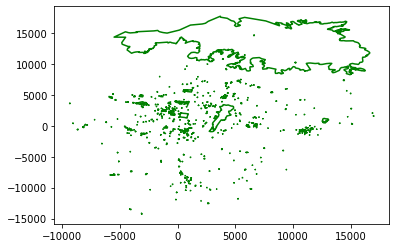

In [3]:
for poly in polys:
  plt.plot(poly[:, 0], poly[:, 1], 'g')

plt.show()

In [13]:
from shapely.geometry import Point, Polygon, LineString, MultiPoint, box

In [175]:
def ray_casting_check(point, polys):
#   point = Point(point_coord)
  for poly in polys:
    polygon = Polygon(poly)
    if polygon.contains(point):
      return True
  
  return False

In [249]:
%%timeit
ray_casting_check(Point([10000, 11000]), polys)

19.5 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
from shapely.ops import triangulate
import triangle as tr

In [8]:
# %%timeit
poly1 = Polygon(polys[0])
delaunay = triangulate(poly1)
clipped_delaunay = [triangle for triangle in triangulate(poly1) if triangle.within(poly1)]

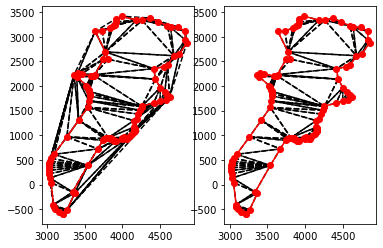

In [9]:
plt.subplot(1, 2, 1)

for poly in delaunay:
   plt.plot(*poly.exterior.xy, 'k--')

plt.plot(*poly1.exterior.xy, 'ro-')

plt.subplot(1, 2, 2)

for poly in clipped_delaunay:
   plt.plot(*poly.exterior.xy, 'k--')

plt.plot(*poly1.exterior.xy, 'ro-')
  
plt.show()

In [10]:
# # %%timeit
# vertices = []
# segments = []
# v = len(poly1.exterior.coords)

# for i, coords in enumerate(list(poly1.exterior.coords)):
#   vertices.append(coords)
#   segments.append([i, (i+1)%v])
  
# poly = dict(vertices=np.array(vertices), segments=np.array(segments))
# t = tr.triangulate(poly, 'p')

# tr.compare(plt, poly, t)
# plt.show()

In [15]:
# pls send shapely polygons
def delta_bounding_box(poly, delta=0.2):
  x_min, y_min, x_max, y_max = poly.bounds
  delta_x = delta*(x_max-x_min)
  delta_y = delta*(y_max-y_min)
  
  return box(x_min-delta_x, y_min-delta_y, x_max+delta_x, y_max+delta_y)

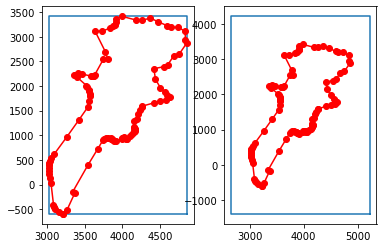

In [26]:
plt.subplot(1, 2, 1)

min_box = box(*poly1.bounds)
plt.plot(*min_box.exterior.xy)
plt.plot(*poly1.exterior.xy, 'ro-')

plt.subplot(1, 2, 2)

delta_box = delta_bounding_box(poly1)
plt.plot(*delta_box.exterior.xy)
plt.plot(*poly1.exterior.xy, 'ro-')

plt.show()

In [101]:
# joining bounding box and polygon
poly1_points = np.array(poly1.exterior.coords)

min_x_points = poly1_points[np.where(poly1_points[:, 0]==min(x))]
min_point = min_x_points[np.argmin(poly1_points[:, 1])]

shared_line = LineString([Point(delta_box.bounds[:2]), min_point])

merged = poly1.boundary.union(shared_line.union(delta_box.boundary))

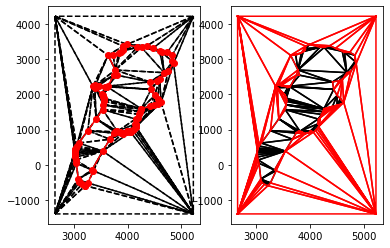

In [106]:
merged_delaunay = triangulate(merged)
inner = [triangle for triangle in merged_delaunay if triangle.within(poly1)]
outer = [triangle for triangle in merged_delaunay if not triangle.within(poly1)]

plt.subplot(1, 2, 1)

for poly in merged_delaunay:
   plt.plot(*poly.exterior.xy, 'k--')

plt.plot(*poly1.exterior.xy, 'ro-')

plt.subplot(1, 2, 2)

for poly in inner:
   plt.plot(*poly.exterior.xy, 'k-')
    
for poly in outer:
   plt.plot(*poly.exterior.xy, 'r-')

plt.show()

In [172]:
list(inner[1].exterior.coords)[:3][2][0]

[(3022.6748383198865, 389.5699966214597),
 (3539.556546382024, 388.3281959570013),
 (3029.0295707796467, 433.62010694528)]

In [240]:
# triangle occupancy check
# use shapely objects
def triangle_occupied(point, triangle):
  x = point.x
  y = point.y
  triangle_points = list(triangle.exterior.coords)[:3]
  w1 = ((triangle_points[2][0]-triangle_points[1][0])*(y-triangle_points[1][1])-(triangle_points[2][1]-triangle_points[1][1])*(x-triangle_points[1][0])) / ((triangle_points[2][0]-triangle_points[1][0])*(triangle_points[0][1]-triangle_points[1][1])-(triangle_points[2][1]-triangle_points[1][1])*(triangle_points[0][0]-triangle_points[1][0]))
  w2 = ((triangle_points[0][0]-triangle_points[2][0])*(y-triangle_points[2][1])-(triangle_points[0][1]-triangle_points[2][1])*(x-triangle_points[2][0])) / ((triangle_points[0][0]-triangle_points[2][0])*(triangle_points[1][1]-triangle_points[2][1])-(triangle_points[0][1]-triangle_points[2][1])*(triangle_points[1][0]-triangle_points[2][0]))
  w3 = ((triangle_points[1][0]-triangle_points[0][0])*(y-triangle_points[0][1])-(triangle_points[1][1]-triangle_points[0][1])*(x-triangle_points[0][0])) / ((triangle_points[1][0]-triangle_points[0][0])*(triangle_points[2][1]-triangle_points[0][1])-(triangle_points[1][1]-triangle_points[0][1])*(triangle_points[2][0]-triangle_points[0][0]))
  
  if w1>0 and w2>0 and w3>0:
    return True
  else:
    return False

In [190]:
triangle_occupied(inner[1], Point([3023.6748383198865, 388.5699966214597]))

False

In [212]:
inner[0].touches(inner[6])

False

In [218]:
# adjacency list from list of triangles
graph = {}


# using only inner triangles for keep-out geofence
for i, triangle in enumerate(inner):
  adjacent = set()
  for j, other_triangle in enumerate(inner):
    if triangle.touches(other_triangle):
      adjacent.add(j)
  
  graph[i] = adjacent

In [238]:
inner[2].exterior.coords.xy

(array('d', [3022.6748383198865, 3029.0295707796467, 3026.220164375729, 3022.6748383198865]),
 array('d', [389.5699966214597, 433.62010694528, 420.2120786262676, 389.5699966214597]))

In [248]:
%%timeit
# BFS for TWCA
from collections import deque

point = Point([3022.6748383198865, 388.5699966214597])

root = 77
visited = set()
queue = deque([root])

visited.add(root)

while queue:
  current = queue.popleft() 
#   print("Traversing ", current)
  if triangle_occupied(point, inner[current]):
#     print("Point occupies triangle no.", current)
    break

  for adj_node in graph[current]:
    if adj_node not in visited:
      visited.add(adj_node)
      queue.append(adj_node)

5.4 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
